# Hands-on Day 4

## You'll learn

### ML methods

- Gradient Boosting Trees with xgboost

### ML techniques
- hyperparameter optimisation
- ROC curves

# Initial setup 

- read in parquet file
- create x,y vectors from panda dataframe

In [1]:
%reload_ext custom_functions
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Check out these custom functions
from custom_functions import *

In [3]:
inputFile = 'file:///home/jovyan/Higgs100k.parquet'
# inputFile = 'file:///home/jovyan/Higgs1M.parquet'
# inputFile = 'file:///home/jovyan/Higgs10M.parquet'

%time df = pd.read_parquet(inputFile)

CPU times: user 187 ms, sys: 245 ms, total: 432 ms
Wall time: 214 ms


In [4]:
# The first column is the target variable
y = df.iloc[:, 0] #df with label
x = df.iloc[: , 1:] #df with all other variables

len(x)

99999

In [5]:
from sklearn.model_selection import train_test_split

# Split the data into training and test sets (80% training, 20% testing)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [6]:
#sanity check

print(len(x_train)+len(x_test))
print(len(y_train)+len(y_test))

99999
99999


# ML model: GBT

- xgboost uses the parameter n_jobs to spawn multi-core jobs on the SAME machine
- do not abuse it or you'll eat up all resources (set it to 5 max)

In [7]:
# DO NOT Use all available cores NJOBS = -1 
NJOBS = 8

In [8]:
!nproc

64


In [9]:
# !pip install xgboost

In [10]:
import xgboost as xgb

# Define the XGBoost classifier with multi-core support
gbt = xgb.XGBClassifier(
    n_estimators=100,      # Number of trees (can be adjusted)
    max_depth=6,           # Maximum depth of each tree (can be tuned)
    learning_rate=0.1,     # Learning rate (can be tuned)
    n_jobs=NJOBS,             # DO NOT Use all available cores
    verbosity=1            # Set verbosity level to monitor training progress
)


In [11]:
# Train the model
%time gbt.fit(x_train, y_train)


CPU times: user 6.39 s, sys: 88.6 ms, total: 6.48 s
Wall time: 861 ms


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=8,
              num_parallel_tree=None, random_state=None, ...)

In [12]:
# Make predictions on the test set
y_pred = gbt.predict(x_test)

In [13]:
# Evaluate the model
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='binary')  # For binary classification
recall = recall_score(y_test, y_pred, average='binary')
f1 = f1_score(y_test, y_pred, average='binary')

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

Accuracy: 0.7294
Precision: 0.7437
Recall: 0.7498
F1-Score: 0.7467


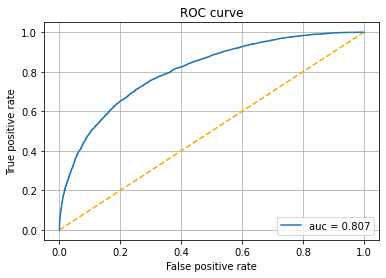

In [14]:
# Get predicted probabilities for the positive class
y_scores = gbt.predict_proba(x_test)[:, 1]

#make ROC curve
drawROC2(y_test, y_scores)

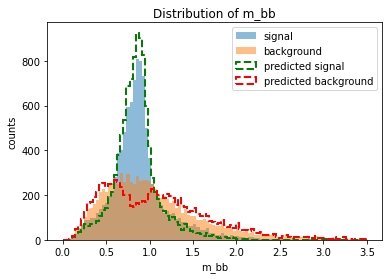

In [15]:
#plot signal vs background with prediction
variable = 'm_bb'
plotSignalvsBgWithPrediction2(x_test.loc[:, variable], y_test, y_pred)

Feature Importance Ranking:
                     Feature  Importance
25                      m_bb    0.159220
26                     m_wbb    0.095197
27                    m_wwbb    0.087621
5                    jet1_pt    0.068382
22                     m_jjj    0.068179
24                     m_jlv    0.058946
8                 jet1_b-tag    0.052134
3   missing_energy_magnitude    0.037450
21                      m_jj    0.036863
0                  lepton_pT    0.034664
9                    jet2_pt    0.031197
16                jet3_b-tag    0.025195
20                jet4_b-tag    0.021892
23                      m_lv    0.021795
13                   jet3_pt    0.021421
17                   jet4_pt    0.020732
12                jet2_b-tag    0.020010
6                   jet1_eta    0.015013
1                 lepton_eta    0.014815
10                  jet2_eta    0.013962
14                  jet3_eta    0.013611
18                   je4_eta    0.012752
11                  jet2_phi 

<Figure size 720x432 with 0 Axes>

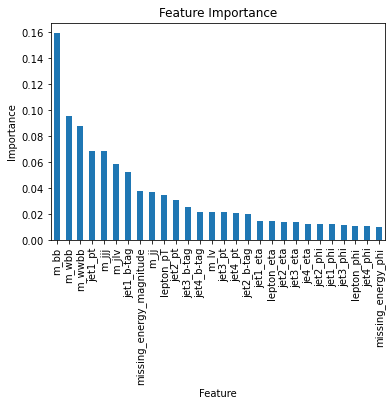

In [16]:
#draw feature importance
drawFeaturesXgb(x, gbt)

# Hyperparameter scan

In [ ]:
# Get the default hyperparameters
default_params = gbt.get_params()

# Print the default hyperparameters
for param, value in default_params.items():
    print(f"{param}: {value}")

## Exercise 1

- do hyperparameter optimisation using Randomized Grid search
- select a reasonable number and range of hyperparameters
- DO NOT USE all possible cores (check sklearn doc)
- while the code runs, check with top that there are indeed several python processes running
- check metrics (accuracy, ROC curve, signal vs background, feature ranking)

In [17]:
from sklearn.model_selection import RandomizedSearchCV

# Initialize the model
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric="mlogloss")

# Define the parameter distribution
param_dist = {
    'n_estimators': [50, 100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],
    'max_depth': [3, 5, 7, 10],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

In [18]:
# Set up RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=xgb_model, param_distributions=param_dist, n_iter=20, scoring='accuracy', cv=3, n_jobs=NJOBS, verbose=1, random_state=42)

In [19]:
# Run random search
%time random_search.fit(x_train, y_train)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


/opt/conda/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [15:01:59] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


CPU times: user 7min 53s, sys: 13.9 s, total: 8min 7s
Wall time: 32.1 s


RandomizedSearchCV(cv=3,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric='mlogloss',
                                           feature_types=None, gamma=None,
                                           grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learnin...
                                           monotone_constraints=None,
                         

In [20]:
# Best parameters and best score
print("Best parameters found: ", random_search.best_params_)
print("Best accuracy: ", random_search.best_score_)

Best parameters found:  {'subsample': 0.8, 'n_estimators': 100, 'max_depth': 10, 'learning_rate': 0.05, 'colsample_bytree': 0.8}
Best accuracy:  0.7219590148695479


In [21]:
# Evaluate the best model on the test set
best_model = random_search.best_estimator_
y_pred = best_model.predict(x_test)

In [22]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='binary')  # For binary classification
recall = recall_score(y_test, y_pred, average='binary')
f1 = f1_score(y_test, y_pred, average='binary')

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

Accuracy: 0.7301
Precision: 0.7441
Recall: 0.7511
F1-Score: 0.7476


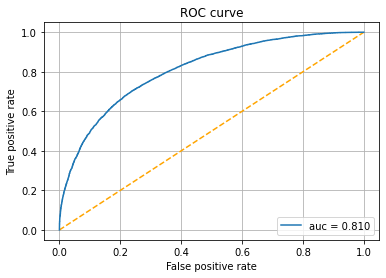

In [23]:
# Get predicted probabilities for the positive class
y_scores = best_model.predict_proba(x_test)[:, 1]

#make ROC curve
drawROC2(y_test, y_scores)

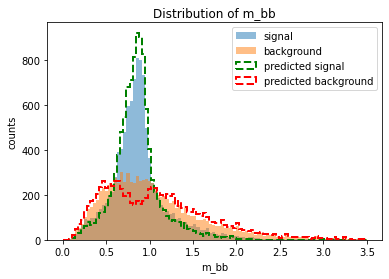

In [24]:
#plot signal vs background with prediction
variable = 'm_bb'
plotSignalvsBgWithPrediction2(x_test.loc[:, variable], y_test, y_pred)

## Exercise 2

- Run the best model on full dataset

In [25]:
inputFile = 'file:///home/jovyan/Higgs10M.parquet'

%time df = pd.read_parquet(inputFile)

CPU times: user 5.59 s, sys: 19.1 s, total: 24.7 s
Wall time: 1.12 s


In [26]:
#create train/test set
y = df.iloc[:, 0] #df with label
x = df.iloc[: , 1:] #df with all other variables

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
len(y)

10000000

In [27]:
# Define the XGBoost classifier with multi-core support
best_gbt = xgb.XGBClassifier(
    n_estimators=random_search.best_params_['n_estimators'],      # Number of trees 
    max_depth=random_search.best_params_['max_depth'],           # Maximum depth of each tree 
    learning_rate=random_search.best_params_['learning_rate'],     # Learning rate
    subsample=random_search.best_params_['subsample'],
    colsample_bytree=random_search.best_params_['colsample_bytree'],
    n_jobs=NJOBS,             # DO NOT Use all available cores
    verbosity=1            # Set verbosity level to monitor training progress
)


In [28]:
# Train the model
%time best_gbt.fit(x_train, y_train)


CPU times: user 9min 50s, sys: 36.8 s, total: 10min 27s
Wall time: 1min 38s


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=8,
              num_parallel_tree=None, random_state=None, ...)

In [29]:
# Make predictions on the test set
y_pred = best_gbt.predict(x_test)

In [30]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='binary')  # For binary classification
recall = recall_score(y_test, y_pred, average='binary')
f1 = f1_score(y_test, y_pred, average='binary')

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

Accuracy: 0.7427
Precision: 0.7535
Recall: 0.7643
F1-Score: 0.7589


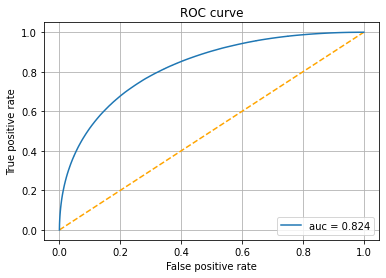

In [31]:
# Get predicted probabilities for the positive class
y_scores = best_gbt.predict_proba(x_test)[:, 1]

#make ROC curve
drawROC2(y_test, y_scores)

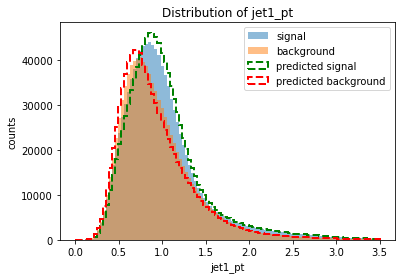

In [37]:
#plot signal vs background with prediction
variable = 'jet1_pt'
plotSignalvsBgWithPrediction2(x_test.loc[:, variable], y_test, y_pred)

Feature Importance Ranking:
                     Feature  Importance
25                      m_bb    0.255166
27                    m_wwbb    0.104593
26                     m_wbb    0.086471
22                     m_jjj    0.077831
5                    jet1_pt    0.070273
24                     m_jlv    0.062203
21                      m_jj    0.036447
3   missing_energy_magnitude    0.034949
8                 jet1_b-tag    0.034174
0                  lepton_pT    0.032175
9                    jet2_pt    0.030429
20                jet4_b-tag    0.026658
16                jet3_b-tag    0.024463
12                jet2_b-tag    0.024243
23                      m_lv    0.020040
13                   jet3_pt    0.017872
17                   jet4_pt    0.016366
1                 lepton_eta    0.010691
6                   jet1_eta    0.008717
10                  jet2_eta    0.005821
14                  jet3_eta    0.005394
18                   je4_eta    0.004923
7                   jet1_phi 

<Figure size 720x432 with 0 Axes>

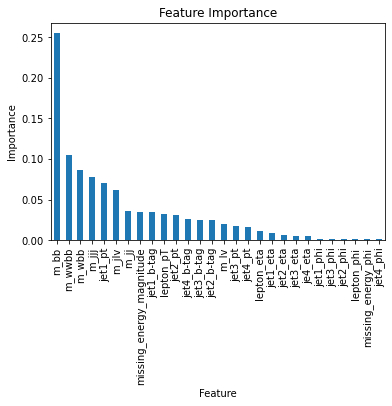

In [33]:
# draw feature importance
drawFeaturesXgb(x, best_gbt)